In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [5]:
# 1. Завантажити дані ТТН
df = pd.read_csv('Ввіз 01.06.2025- 30.10.2025.csv', sep=';')
df

,№,ТТН,НомерРядка,ТочкаБП,Час реєстрації,Оператор
0,1,ТТН ввоз (элеватор) SEMEN000519 от 08.07.2025 ...,1,Диспетчер вїзду,08.07.2025 15:42:23,Бондарчук Юлія Олексіївна
1,2,ТТН ввоз (элеватор) SEMEN000519 от 08.07.2025 ...,2,Вїзд шлагбаум,08.07.2025 15:50:26,UserForPost
2,3,ТТН ввоз (элеватор) SEMEN000519 от 08.07.2025 ...,3,Початок відбору проб,08.07.2025 15:51:06,UserForPost
3,4,ТТН ввоз (элеватор) SEMEN000519 от 08.07.2025 ...,4,Кінець відбору проб,08.07.2025 15:53:45,UserForPost
4,5,ТТН ввоз (элеватор) SEMEN000519 от 08.07.2025 ...,5,Зважування брутто,08.07.2025 15:53:50,UserForPost
...,...,...,...,...,...,...
47495,47496,ТТН ввоз (элеватор) SEMEN002729 от 07.08.2025 ...,6,Лабораторний аналіз,07.08.2025 15:56:19,Калантиря Ліна Миколаївна
47496,47497,ТТН ввоз (элеватор) SEMEN002729 от 07.08.2025 ...,7,Пункт розгрузки,07.08.2025 16:02:49,UserForPost
47497,47498,ТТН ввоз (элеватор) SEMEN002729 от 07.08.2025 ...,8,Зважування тари,07.08.2025 16:08:14,UserForPost
47498,47499,ТТН ввоз (элеватор) SEMEN002729 от 07.08.2025 ...,9,Вїзд шлагбаум,07.08.2025 16:08:16,UserForPost


In [6]:
# 2. Очистити дані
df["Час реєстрації"] = pd.to_datetime(df['Час реєстрації'], format='%d.%m.%Y %H:%M:%S')
df = df[df['ТочкаБП'].notna()]  # видалити порожні рядки

# 3. Визначити етапи (логіка А1)
stages = {
    'Вїзд': ('Диспетчер вїзду', 'Початок відбору проб'),
    'Відбір_проб': ('Початок відбору проб', 'Кінець відбору проб'),
    'Зважування': ('Зважування брутто', 'Лабораторний аналіз'),
    'Лабораторія': ('Лабораторний аналіз', 'Пункт розгрузки'),
    'Розвантаження': ('Пункт розгрузки', 'Зважування тари'),
    'Виїзд': ('Зважування тари', 'Диспетчер виїзду')
}

# stages = {
#     'До_КПП': ('Диспетчер вїзду', 'Вїзд шлагбаум'),
#     'Відбір_проб': ('Початок відбору проб', 'Кінець відбору проб'),
#     'Зважування_1': ('Кінець відбору проб', 'Зважування брутто'),
#     'Лабораторія': ('Зважування брутто', 'Лабораторний аналіз'),
#     'Очікування': ('Лабораторний аналіз', 'Пункт розгрузки'),  # ← це найчастіше вузьке місце!
#     'Розвантаження': ('Пункт розгрузки', 'Зважування тари'),
#     'Виїзд': ('Зважування тари', 'Диспетчер виїзду')
# }

In [7]:
# Для кожної ТТН розрахувати час на етапах
results = []

for ttn in df['ТТН'].unique():
    ttn_data = df[df['ТТН'] == ttn].sort_values('НомерРядка')
    
    for stage_name, (start_point, end_point) in stages.items():
        start_time = ttn_data[ttn_data['ТочкаБП'] == start_point]['Час реєстрації'].values
        end_time = ttn_data[ttn_data['ТочкаБП'] == end_point]['Час реєстрації'].values
        
        if len(start_time) > 0 and len(end_time) > 0:
            duration = (pd.to_datetime(end_time[0]) - pd.to_datetime(start_time[0])).total_seconds() / 60
            
            results.append({
                'ТТН': ttn,
                'Дата': pd.to_datetime(start_time[0]).date(),
                'Етап': stage_name,
                'Час_хв': duration
            })

df_results = pd.DataFrame(results)

In [8]:
# 1. По днях
daily_bottlenecks = df_results.groupby(['Дата', 'Етап'])['Час_хв'].median().reset_index()
daily_bottlenecks['Вузьке_місце'] = daily_bottlenecks.groupby('Дата')['Час_хв'].transform(lambda x: x == x.max())

# 2. По тижнях
df_results['Тиждень'] = pd.to_datetime(df_results['Дата']).dt.to_period('W')
weekly_bottlenecks = df_results.groupby(['Тиждень', 'Етап'])['Час_хв'].median().reset_index()
weekly_bottlenecks['Вузьке_місце'] = weekly_bottlenecks.groupby('Тиждень')['Час_хв'].transform(lambda x: x == x.max())

# 3. По місяцях
df_results['Місяць'] = pd.to_datetime(df_results['Дата']).dt.to_period('M')
monthly_bottlenecks = df_results.groupby(['Місяць', 'Етап'])['Час_хв'].median().reset_index()
monthly_bottlenecks['Вузьке_місце'] = monthly_bottlenecks.groupby('Місяць')['Час_хв'].transform(lambda x: x == x.max())

# 4. Загальний період
overall_bottlenecks = df_results.groupby('Етап')['Час_хв'].agg(['median', 'mean', 'std'])


In [9]:
# м/год = 60 / середній_час_на_етапі
overall_bottlenecks['м_год'] = 60 / overall_bottlenecks['median']

In [10]:
df_results

,ТТН,Дата,Етап,Час_хв,Тиждень,Місяць
0,ТТН ввоз (элеватор) SEMEN000519 от 08.07.2025 ...,2025-07-08,Вїзд,8.716667,2025-07-07/2025-07-13,2025-07
1,ТТН ввоз (элеватор) SEMEN000519 от 08.07.2025 ...,2025-07-08,Відбір_проб,2.650000,2025-07-07/2025-07-13,2025-07
2,ТТН ввоз (элеватор) SEMEN000519 от 08.07.2025 ...,2025-07-08,Зважування,2.266667,2025-07-07/2025-07-13,2025-07
3,ТТН ввоз (элеватор) SEMEN000519 от 08.07.2025 ...,2025-07-08,Лабораторія,9.250000,2025-07-07/2025-07-13,2025-07
4,ТТН ввоз (элеватор) SEMEN000519 от 08.07.2025 ...,2025-07-08,Розвантаження,2.500000,2025-07-07/2025-07-13,2025-07
...,...,...,...,...,...,...
28495,ТТН ввоз (элеватор) SEMEN002729 от 07.08.2025 ...,2025-08-07,Відбір_проб,2.033333,2025-08-04/2025-08-10,2025-08
28496,ТТН ввоз (элеватор) SEMEN002729 от 07.08.2025 ...,2025-08-07,Зважування,3.383333,2025-08-04/2025-08-10,2025-08
28497,ТТН ввоз (элеватор) SEMEN002729 от 07.08.2025 ...,2025-08-07,Лабораторія,6.500000,2025-08-04/2025-08-10,2025-08
28498,ТТН ввоз (элеватор) SEMEN002729 от 07.08.2025 ...,2025-08-07,Розвантаження,5.416667,2025-08-04/2025-08-10,2025-08


In [11]:
daily_bottlenecks

,Дата,Етап,Час_хв,Вузьке_місце
0,2025-06-10,Виїзд,5.541667,False
1,2025-06-10,Відбір_проб,9.350000,True
2,2025-06-10,Вїзд,1.983333,False
3,2025-06-10,Зважування,2.041667,False
4,2025-06-10,Лабораторія,4.841667,False
...,...,...,...,...
673,2025-10-29,Відбір_проб,1.950000,False
674,2025-10-29,Вїзд,11.216667,False
675,2025-10-29,Зважування,15.616667,True
676,2025-10-29,Лабораторія,12.500000,False


In [12]:
weekly_bottlenecks

,Тиждень,Етап,Час_хв,Вузьке_місце
0,2025-06-09/2025-06-15,Виїзд,5.275000,False
1,2025-06-09/2025-06-15,Відбір_проб,8.875000,True
2,2025-06-09/2025-06-15,Вїзд,2.508333,False
3,2025-06-09/2025-06-15,Зважування,1.858333,False
4,2025-06-09/2025-06-15,Лабораторія,4.908333,False
...,...,...,...,...
109,2025-10-27/2025-11-02,Відбір_проб,1.950000,False
110,2025-10-27/2025-11-02,Вїзд,11.216667,False
111,2025-10-27/2025-11-02,Зважування,15.616667,True
112,2025-10-27/2025-11-02,Лабораторія,11.233333,False


In [13]:
monthly_bottlenecks

,Місяць,Етап,Час_хв,Вузьке_місце
0,2025-06,Виїзд,5.275000,False
1,2025-06,Відбір_проб,8.875000,True
2,2025-06,Вїзд,2.508333,False
3,2025-06,Зважування,1.858333,False
4,2025-06,Лабораторія,4.908333,False
5,2025-06,Розвантаження,4.016667,False
6,2025-07,Виїзд,5.633333,False
7,2025-07,Відбір_проб,2.550000,False
8,2025-07,Вїзд,11.166667,True
9,2025-07,Зважування,3.416667,False


In [14]:
overall_bottlenecks

,median,mean,std,м_год
Етап,,,,
Виїзд,6.650000,12.220365,30.789860,9.022556
Відбір_проб,2.533333,3.040018,2.200704,23.684211
Вїзд,7.883333,21.910084,55.083043,7.610994
Зважування,3.866667,7.321646,25.335685,15.517241
Лабораторія,9.016667,28.526172,58.273711,6.654344
Розвантаження,3.216667,3.772916,2.617110,18.652850


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Налаштування для кириличних шрифтів
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# Кольорова палітра для етапів
# stage_colors = {
#     'До_КПП': '#FF6B6B',
#     'Відбір_проб': '#4ECDC4',
#     'Зважування_1': '#95E1D3',
#     'Лабораторія': '#FFD93D',
#     'Очікування': '#F38181',
#     'Розвантаження': '#AA96DA',
#     'Виїзд': '#6C5CE7'
# }

stage_colors = {
    'Вїзд': '#FF0000',       # red
    'Відбір_проб': '#FF7F00',  # orange
    'Зважування': '#FFFF00', # yellow
    'Лабораторія': '#00FF00',  # green
    'Розвантаження': "#0021C4",# indigo
    'Виїзд': '#8F00FF'         # violet
}


In [16]:

# ====================
# 1. ДИНАМІКА ВУЗЬКИХ МІСЦЬ ПО ДНЯХ (Timeline)
# ====================
def plot_daily_bottleneck_timeline(daily_bottlenecks):
    """Показує, який етап був вузьким місцем кожного дня"""
    
    # Фільтруємо тільки вузькі місця
    bottlenecks_only = daily_bottlenecks[daily_bottlenecks['Вузьке_місце'] == True].copy()
    bottlenecks_only['Дата'] = pd.to_datetime(bottlenecks_only['Дата'])
    
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Створюємо scatter plot з кольорами для кожного етапу
    for stage in bottlenecks_only['Етап'].unique():
        stage_data = bottlenecks_only[bottlenecks_only['Етап'] == stage]
        ax.scatter(stage_data['Дата'], stage_data['Час_хв'], 
                  label=stage, color=stage_colors.get(stage, '#000000'),
                  s=100, alpha=0.7, edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel('Дата', fontsize=12, fontweight='bold')
    ax.set_ylabel('Час (хвилини)', fontsize=12, fontweight='bold')
    ax.set_title('Динаміка вузьких місць по днях', fontsize=14, fontweight='bold', pad=20)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, shadow=True)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    return fig


In [17]:

# ====================
# 2. HEATMAP ВУЗЬКИХ МІСЦЬ ПО ДНЯХ
# ====================
def plot_daily_heatmap(daily_bottlenecks):
    """Heatmap показує час на кожному етапі кожного дня"""
    
    # Підготовка даних для heatmap
    pivot_data = daily_bottlenecks.pivot(index='Дата', columns='Етап', values='Час_хв')
    
    fig, ax = plt.subplots(figsize=(12, 19))
    
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='RdYlGn_r', 
                cbar_kws={'label': 'Час (хв)'}, ax=ax, linewidths=0.5)
    
    ax.set_title('Час на етапах по днях (Heatmap)', fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Етап', fontsize=12, fontweight='bold')
    ax.set_ylabel('Дата', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    return fig


In [18]:

# ====================
# 3. ВАРІАТИВНІСТЬ ВУЗЬКИХ МІСЦЬ
# ====================
def plot_bottleneck_frequency(daily_bottlenecks, weekly_bottlenecks, monthly_bottlenecks):
    """Показує, як часто кожен етап був вузьким місцем"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    periods = [
        (daily_bottlenecks, 'По днях', axes[0]),
        (weekly_bottlenecks, 'По тижнях', axes[1]),
        (monthly_bottlenecks, 'По місяцях', axes[2])
    ]
    
    for data, title, ax in periods:
        # Підрахунок частоти
        bottlenecks_only = data[data['Вузьке_місце'] == True]
        frequency = bottlenecks_only['Етап'].value_counts()
        total = len(bottlenecks_only['Дата'].unique() if 'Дата' in data.columns 
                    else bottlenecks_only['Тиждень'].unique() if 'Тиждень' in data.columns 
                    else bottlenecks_only['Місяць'].unique())
        
        percentages = (frequency / total * 100).sort_values(ascending=True)
        
        colors = [stage_colors.get(stage, '#000000') for stage in percentages.index]
        
        percentages.plot(kind='barh', ax=ax, color=colors, edgecolor='black', linewidth=0.5)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('Відсоток періодів (%)', fontsize=10)
        ax.set_ylabel('')
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        
        # Додаємо значення на стовпчики
        for i, v in enumerate(percentages):
            ax.text(v + 1, i, f'{v:.1f}%', va='center', fontweight='bold')
    
    plt.tight_layout()
    return fig


In [19]:

# ====================
# 4. ДИНАМІКА СЕРЕДНЬОГО ЧАСУ ПО ЕТАПАХ
# ====================
def plot_stage_trends(df_results):
    """Показує тренди часу на кожному етапі протягом періоду"""
    
    # Групуємо по тижнях
    df_results['Тиждень'] = pd.to_datetime(df_results['Дата']).dt.to_period('W')
    weekly_trends = df_results.groupby(['Тиждень', 'Етап'])['Час_хв'].median().reset_index()
    weekly_trends['Тиждень'] = weekly_trends['Тиждень'].dt.to_timestamp()
    
    fig, ax = plt.subplots(figsize=(16, 8))
    
    for stage in weekly_trends['Етап'].unique():
        stage_data = weekly_trends[weekly_trends['Етап'] == stage]
        ax.plot(stage_data['Тиждень'], stage_data['Час_хв'], 
               marker='o', label=stage, color=stage_colors.get(stage, '#000000'),
               linewidth=2, markersize=6)
    
    ax.set_xlabel('Тиждень', fontsize=12, fontweight='bold')
    ax.set_ylabel('Медіанний час (хв)', fontsize=12, fontweight='bold')
    ax.set_title('Тренди часу на етапах по тижнях', fontsize=14, fontweight='bold', pad=20)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, shadow=True)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    return fig


In [20]:

# ====================
# 5. BOX PLOTS ДЛЯ ПОРІВНЯННЯ ВАРІАТИВНОСТІ
# ====================
def plot_stage_boxplots(df_results):
    """Box plots показують розподіл часу на кожному етапі"""
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Сортуємо етапи по медіані
    stage_order = df_results.groupby('Етап')['Час_хв'].median().sort_values(ascending=False).index
    
    colors_list = [stage_colors.get(stage, '#000000') for stage in stage_order]
    
    bp = ax.boxplot([df_results[df_results['Етап'] == stage]['Час_хв'].values 
                      for stage in stage_order],
                    labels=stage_order, patch_artist=True, showmeans=True,
                    meanprops=dict(marker='D', markerfacecolor='red', markersize=8))
    
    for patch, color in zip(bp['boxes'], colors_list):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax.set_ylabel('Час (хвилини)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Етап', fontsize=12, fontweight='bold')
    ax.set_title('Розподіл часу на етапах (Box Plot)', fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    return fig


In [21]:

# ====================
# 6. SUMMARY STATISTICS
# ====================
def create_summary_table(overall_bottlenecks):
    """Створює таблицю зі статистикою по етапах"""
    
    summary = overall_bottlenecks.copy()
    summary = summary.sort_values('median', ascending=False)
    summary = summary.round(2)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('tight')
    ax.axis('off')
    
    table_data = []
    table_data.append(['Етап', 'Медіана (хв)', 'Середнє (хв)', 'Ст.відх. (хв)', 'Пропускна\nздатність (м/год)'])
    
    for idx, row in summary.iterrows():
        table_data.append([
            idx,
            f"{row['median']:.2f}",
            f"{row['mean']:.2f}",
            f"{row['std']:.2f}",
            f"{row['м_год']:.1f}"
        ])
    
    table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                    colWidths=[0.25, 0.15, 0.15, 0.15, 0.2])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Стилізація заголовка
    for i in range(5):
        cell = table[(0, i)]
        cell.set_facecolor('#4ECDC4')
        cell.set_text_props(weight='bold', color='white')
    
    # Стилізація рядків
    for i in range(1, len(table_data)):
        for j in range(5):
            cell = table[(i, j)]
            if i % 2 == 0:
                cell.set_facecolor('#F0F0F0')
    
    ax.set_title('Загальна статистика по етапах', fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig


ГЕНЕРАЦІЯ ВІЗУАЛІЗАЦІЙ ВУЗЬКИХ МІСЦЬ ЕЛЕВАТОРА

1. Створення timeline вузьких місць...
   ✓ Збережено: 01_daily_bottleneck_timeline.png


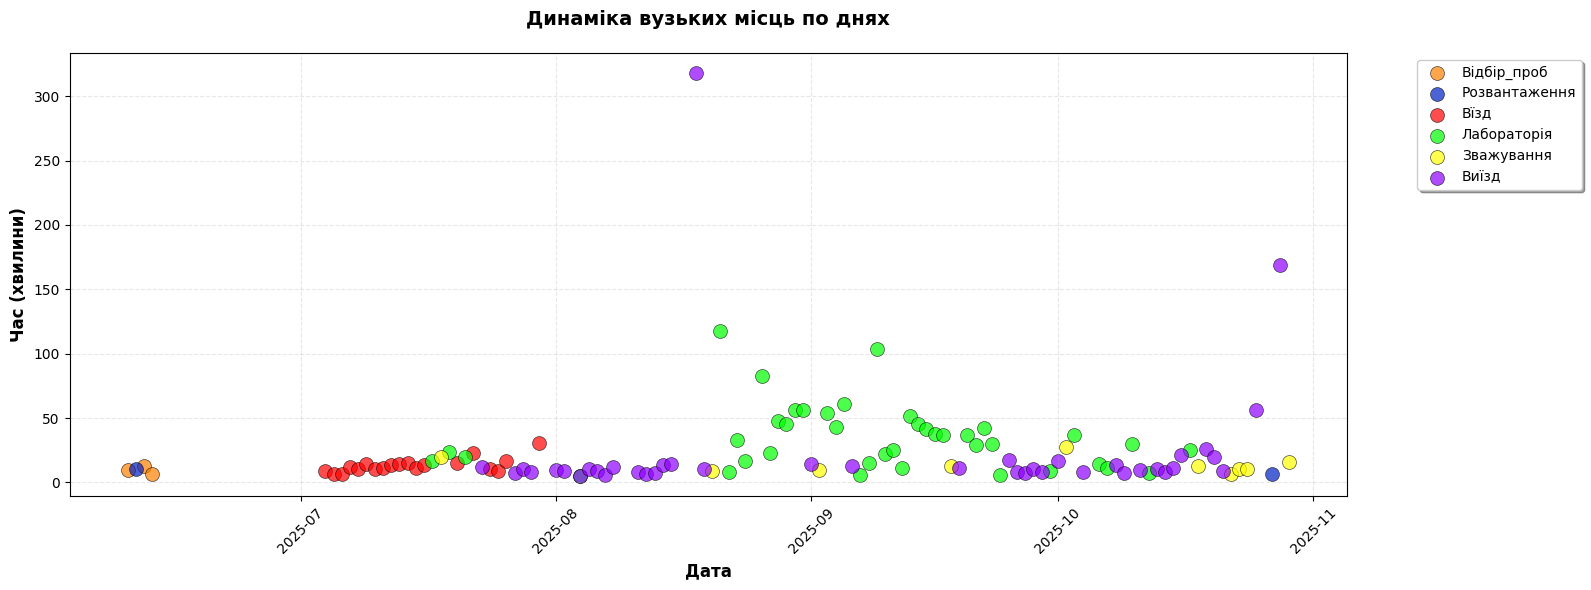

In [22]:

# ====================
# ВИКОНАННЯ ВСІХ ВІЗУАЛІЗАЦІЙ
# ====================
# Припускаємо, що ви вже маєте ці змінні з попереднього коду:
# daily_bottlenecks, weekly_bottlenecks, monthly_bottlenecks, df_results, overall_bottlenecks

print("=" * 60)
print("ГЕНЕРАЦІЯ ВІЗУАЛІЗАЦІЙ ВУЗЬКИХ МІСЦЬ ЕЛЕВАТОРА")
print("=" * 60)

# 1. Timeline вузьких місць
print("\n1. Створення timeline вузьких місць...")
fig1 = plot_daily_bottleneck_timeline(daily_bottlenecks)
plt.savefig('01_daily_bottleneck_timeline.png', dpi=300, bbox_inches='tight')
print("   ✓ Збережено: 01_daily_bottleneck_timeline.png")



2. Створення heatmap...
   ✓ Збережено: 02_daily_heatmap.png


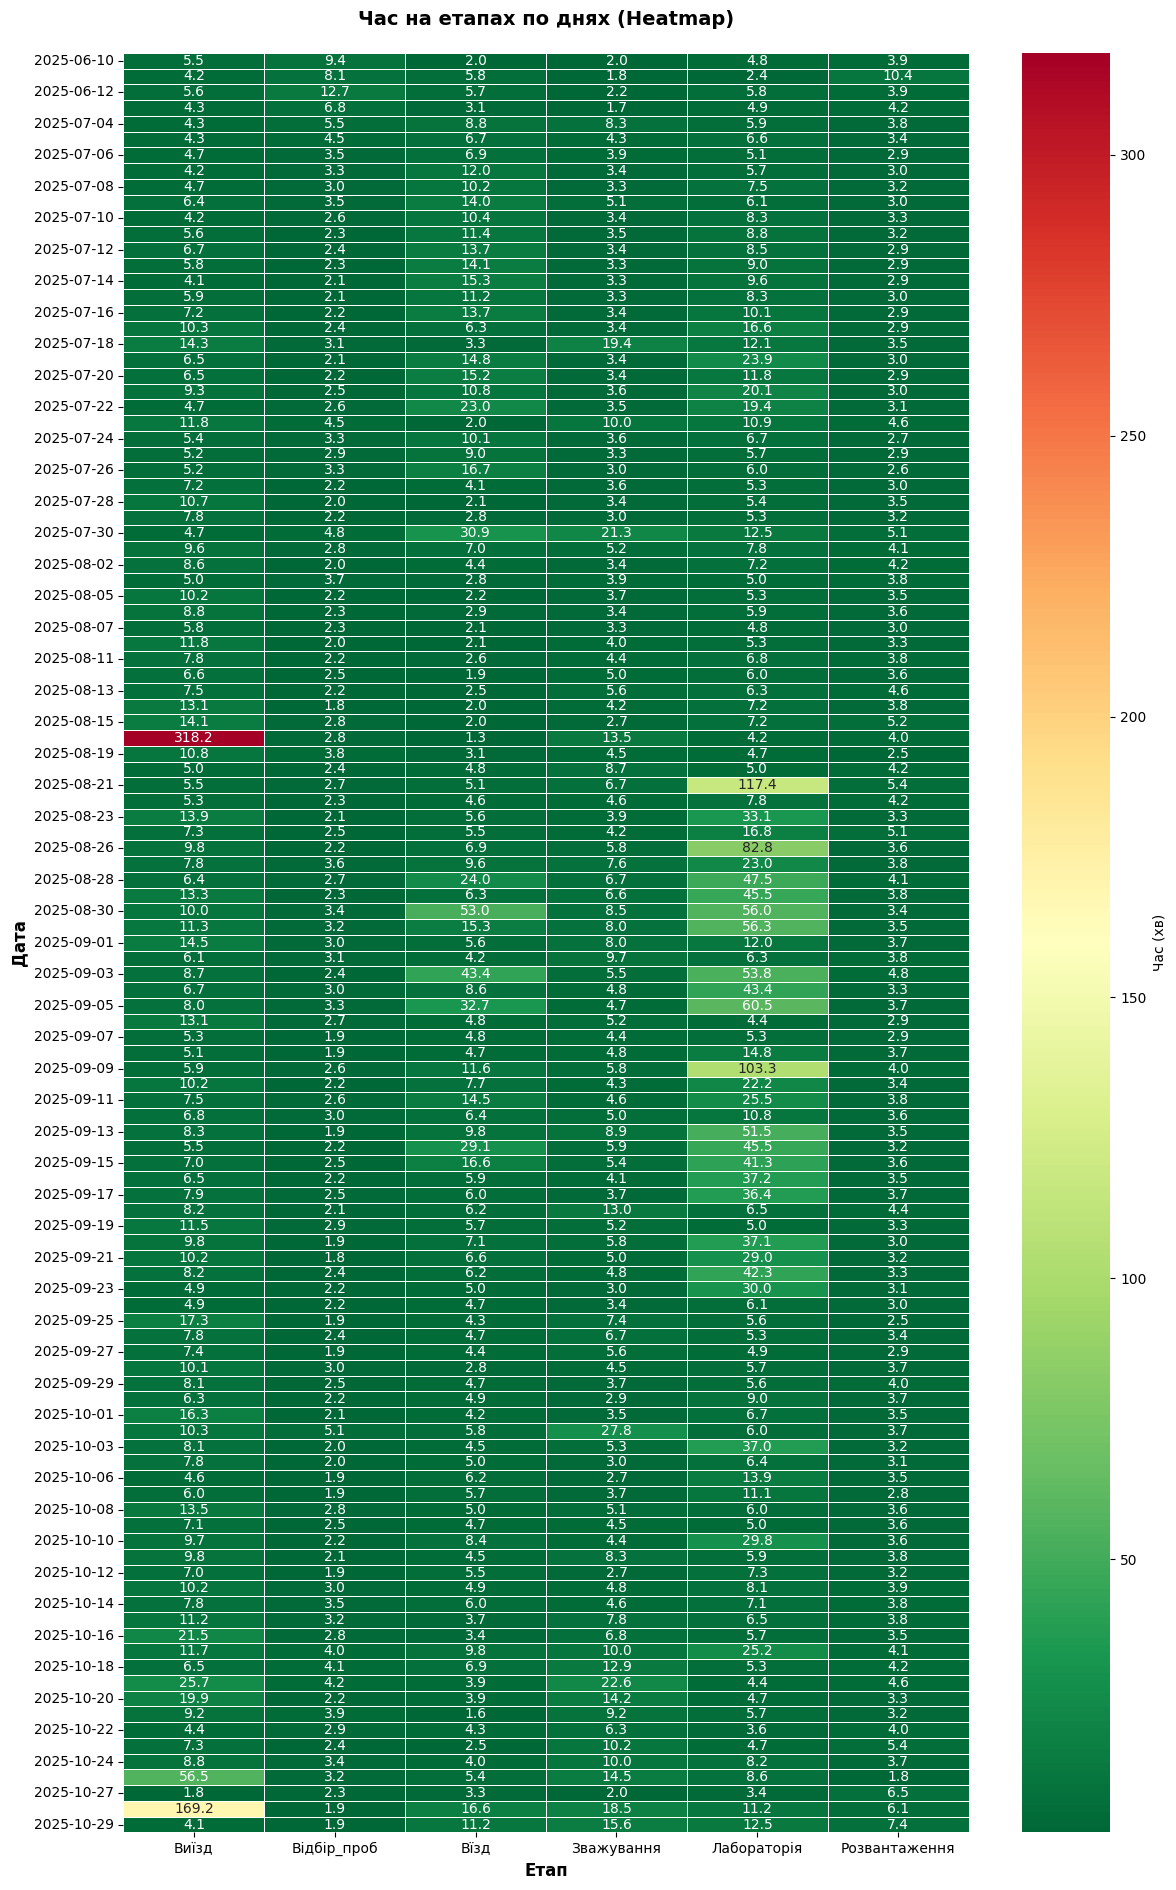

In [23]:

# 2. Heatmap
print("\n2. Створення heatmap...")
fig2 = plot_daily_heatmap(daily_bottlenecks)
plt.savefig('02_daily_heatmap.png', dpi=300, bbox_inches='tight')
print("   ✓ Збережено: 02_daily_heatmap.png")



3. Створення графіків варіативності...
   ✓ Збережено: 03_bottleneck_frequency.png


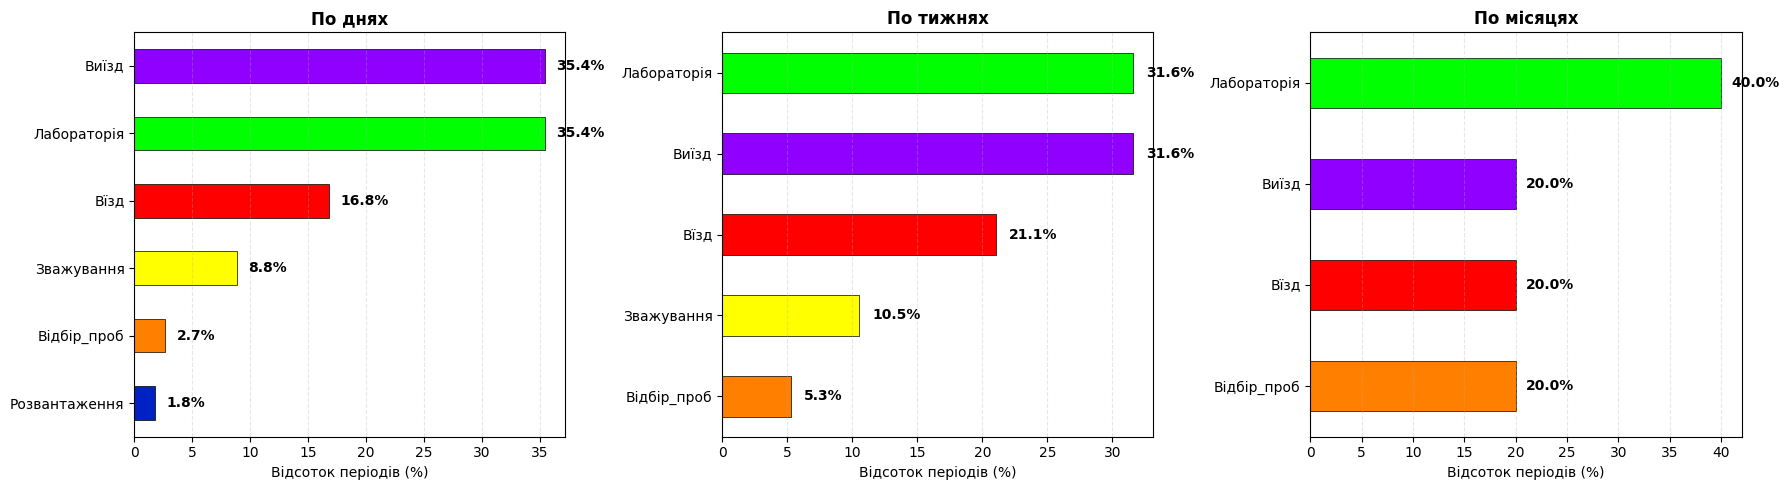

In [24]:

# 3. Варіативність
print("\n3. Створення графіків варіативності...")
fig3 = plot_bottleneck_frequency(daily_bottlenecks, weekly_bottlenecks, monthly_bottlenecks)
plt.savefig('03_bottleneck_frequency.png', dpi=300, bbox_inches='tight')
print("   ✓ Збережено: 03_bottleneck_frequency.png")



4. Створення трендів по тижнях...
   ✓ Збережено: 04_stage_trends.png


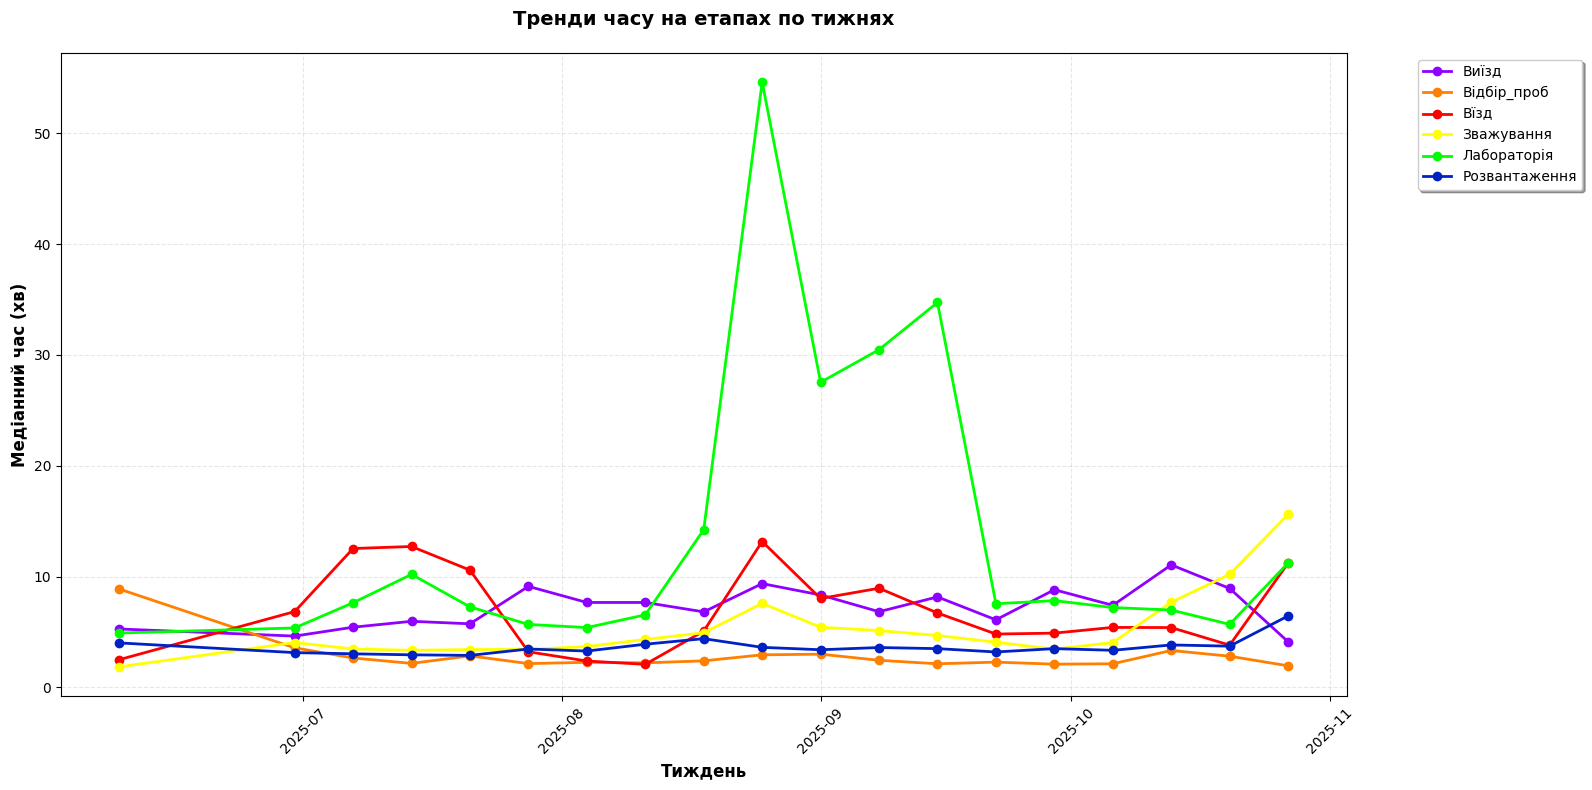

In [25]:

# 4. Тренди
print("\n4. Створення трендів по тижнях...")
fig4 = plot_stage_trends(df_results)
plt.savefig('04_stage_trends.png', dpi=300, bbox_inches='tight')
print("   ✓ Збережено: 04_stage_trends.png")



5. Створення box plots...
   ✓ Збережено: 05_stage_boxplots.png


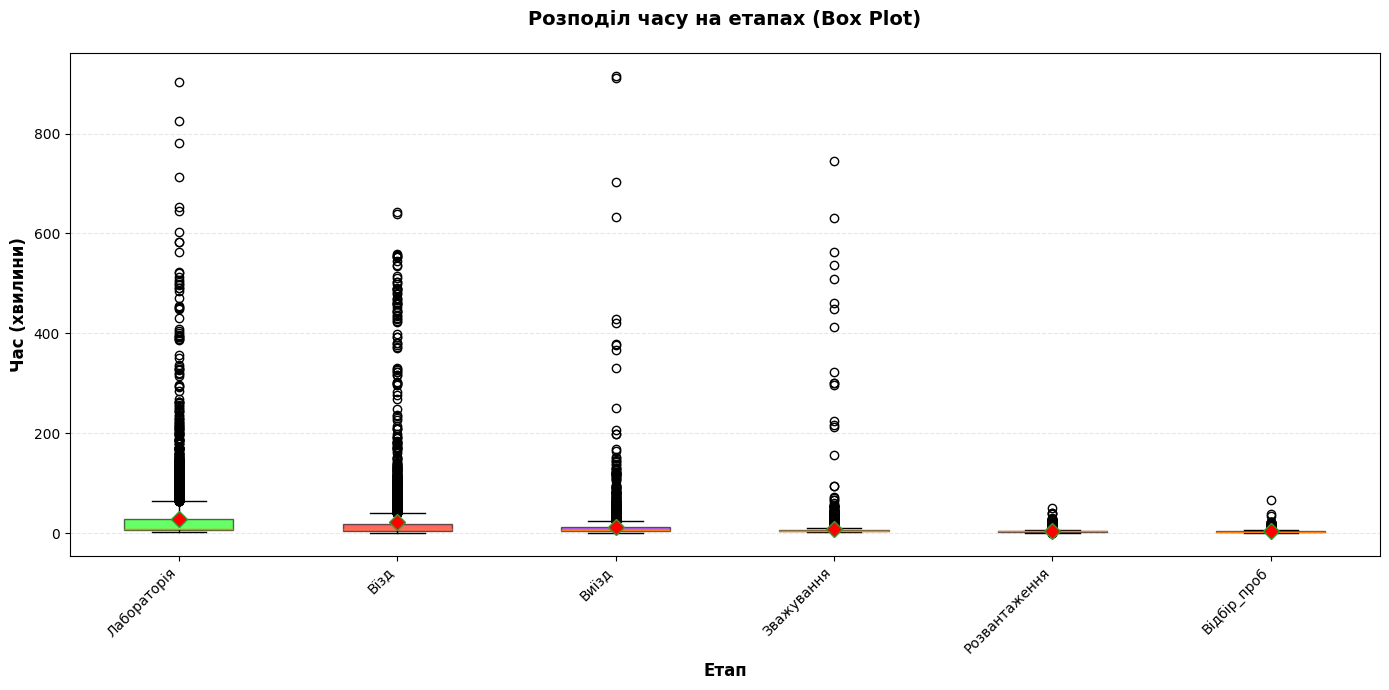

In [26]:

# 5. Box plots
print("\n5. Створення box plots...")
fig5 = plot_stage_boxplots(df_results)
plt.savefig('05_stage_boxplots.png', dpi=300, bbox_inches='tight')
print("   ✓ Збережено: 05_stage_boxplots.png")



6. Створення таблиці статистики...
   ✓ Збережено: 06_summary_table.png

ВІЗУАЛІЗАЦІЇ СТВОРЕНО!


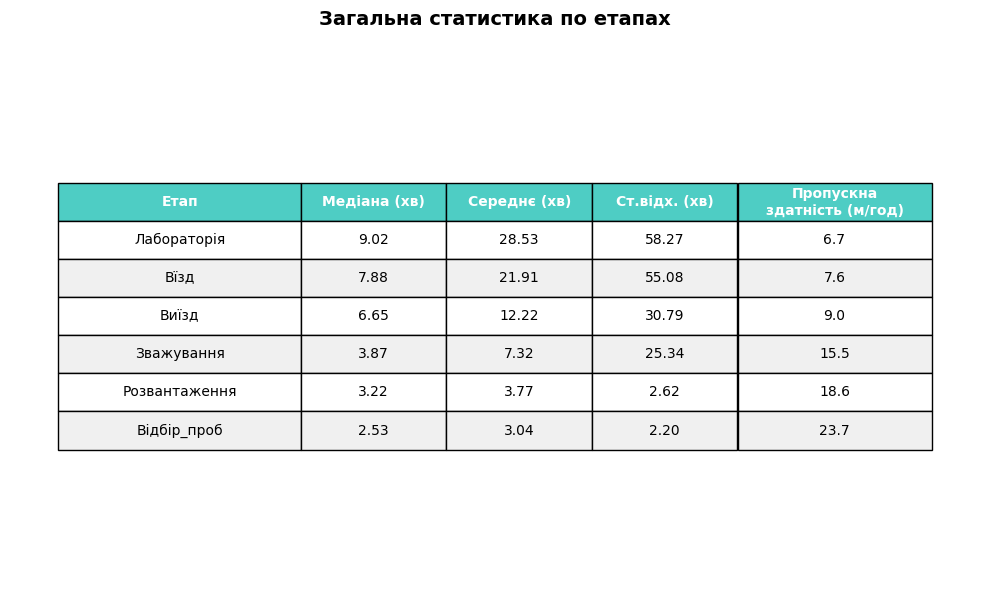

In [27]:

# 6. Summary table
print("\n6. Створення таблиці статистики...")
fig6 = create_summary_table(overall_bottlenecks)
plt.savefig('06_summary_table.png', dpi=300, bbox_inches='tight')
print("   ✓ Збережено: 06_summary_table.png")

print("\n" + "=" * 60)
print("ВІЗУАЛІЗАЦІЇ СТВОРЕНО!")
print("=" * 60)


In [28]:
# ====================
# ДОДАТКОВИЙ АНАЛІЗ: ВИВЕДЕННЯ КЛЮЧОВИХ ІНСАЙТІВ
# ====================
print("\n\n📊 КЛЮЧОВІ ІНСАЙТИ:")
print("=" * 60)

# 1. Найчастіше вузьке місце
bottlenecks_daily = daily_bottlenecks[daily_bottlenecks['Вузьке_місце'] == True]
most_common = bottlenecks_daily['Етап'].value_counts().head(1)
print(f"\n1. Найчастіше вузьке місце:")
print(f"   {most_common.index[0]} - {most_common.values[0]} днів ({most_common.values[0]/len(bottlenecks_daily['Дата'].unique())*100:.1f}%)")

# 2. Найповільніший етап
slowest = overall_bottlenecks['median'].idxmax()
print(f"\n2. Найповільніший етап (медіана):")
print(f"   {slowest} - {overall_bottlenecks.loc[slowest, 'median']:.1f} хв")

# 3. Етап з найбільшою варіативністю
most_variable = overall_bottlenecks['std'].idxmax()
print(f"\n3. Етап з найбільшою варіативністю:")
print(f"   {most_variable} - ст.відх. {overall_bottlenecks.loc[most_variable, 'std']:.1f} хв")

# 4. Найнижча пропускна здатність
lowest_throughput = overall_bottlenecks['м_год'].idxmin()
print(f"\n4. Найнижча пропускна здатність:")
print(f"   {lowest_throughput} - {overall_bottlenecks.loc[lowest_throughput, 'м_год']:.1f} м/год")

# 5. Зміна вузьких місць по тижнях
print(f"\n5. Вузькі місця по тижнях:")
weekly_bn = weekly_bottlenecks[weekly_bottlenecks['Вузьке_місце'] == True]
for _, row in weekly_bn.iterrows():
    print(f"   {row['Тиждень']}: {row['Етап']} ({row['Час_хв']:.1f} хв)")

# 6. Зміна вузьких місць по місяцях
print(f"\n6. Вузькі місця по місяцях:")
monthly_bn = monthly_bottlenecks[monthly_bottlenecks['Вузьке_місце'] == True]
for _, row in monthly_bn.iterrows():
    print(f"   {row['Місяць']}: {row['Етап']} ({row['Час_хв']:.1f} хв)")

print("\n" + "=" * 60)

plt.show()



📊 КЛЮЧОВІ ІНСАЙТИ:

1. Найчастіше вузьке місце:
   Лабораторія - 40 днів (35.4%)

2. Найповільніший етап (медіана):
   Лабораторія - 9.0 хв

3. Етап з найбільшою варіативністю:
   Лабораторія - ст.відх. 58.3 хв

4. Найнижча пропускна здатність:
   Лабораторія - 6.7 м/год

5. Вузькі місця по тижнях:
   2025-06-09/2025-06-15: Відбір_проб (8.9 хв)
   2025-06-30/2025-07-06: Вїзд (6.8 хв)
   2025-07-07/2025-07-13: Вїзд (12.5 хв)
   2025-07-14/2025-07-20: Вїзд (12.7 хв)
   2025-07-21/2025-07-27: Вїзд (10.6 хв)
   2025-07-28/2025-08-03: Виїзд (9.1 хв)
   2025-08-04/2025-08-10: Виїзд (7.7 хв)
   2025-08-11/2025-08-17: Виїзд (7.7 хв)
   2025-08-18/2025-08-24: Лабораторія (14.2 хв)
   2025-08-25/2025-08-31: Лабораторія (54.6 хв)
   2025-09-01/2025-09-07: Лабораторія (27.5 хв)
   2025-09-08/2025-09-14: Лабораторія (30.5 хв)
   2025-09-15/2025-09-21: Лабораторія (34.7 хв)
   2025-09-22/2025-09-28: Лабораторія (7.5 хв)
   2025-09-29/2025-10-05: Виїзд (8.8 хв)
   2025-10-06/2025-10-12: Виїзд (7.4 

### Аналізуємо окремо Лабораторію і Очікування

In [33]:
def analyze_separate_stages(lab_file='03_Лабораторія.csv', waiting_file='05_Зона очікування.csv'):
    """
    Аналізує етапи Лабораторія та Очікування з окремих CSV файлів
    використовуючи Стратегію А2 (дельти між суміжними початками)
    """
    
    # Завантажити дані
    lab_df = pd.read_csv(lab_file, sep=';', encoding='utf-8')
    waiting_df = pd.read_csv(waiting_file, sep=';', encoding='utf-8')
    
    # Очистити назви колонок від пробілів
    lab_df.columns = lab_df.columns.str.strip()
    waiting_df.columns = waiting_df.columns.str.strip()
    
    results = {}
    
    for name, df, column_name in [('Лабораторія_окремо', lab_df, 'DT'), 
                                    ('Очікування_окремо', waiting_df, 'DT')]:
        # Пропустити порожні рядки на початку
        df = df[df[column_name].notna()].copy()
        
        # Парсинг дати
        df['Час'] = pd.to_datetime(df[column_name], format='%d.%m.%Y %H:%M', errors='coerce')
        df = df[df['Час'].notna()].sort_values('Час')
        
        # Розрахунок дельт (час між прибуттям машин)
        df['Дельта_хв'] = df['Час'].diff().dt.total_seconds() / 60
        
        # Фільтрація викидів (видаляємо дельти > 60 хв, бо це перерви)
        deltas_filtered = df['Дельта_хв'][
            (df['Дельта_хв'] > 0) & (df['Дельта_хв'] <= 60)
        ]
        
        if len(deltas_filtered) > 0:
            results[name] = {
                'median': deltas_filtered.median(),
                'mean': deltas_filtered.mean(),
                'std': deltas_filtered.std(),
                'м_год': 60 / deltas_filtered.median() if deltas_filtered.median() > 0 else 0
            }
        else:
            results[name] = {
                'median': 0,
                'mean': 0,
                'std': 0,
                'м_год': 0
            }
    
    return pd.DataFrame(results).T


In [34]:
def create_combined_summary_table(overall_bottlenecks, separate_stages_file_lab='03_Лабораторія.csv', 
                                   separate_stages_file_waiting='05_Зона очікування.csv'):
    """
    Створює таблицю зі статистикою, включаючи окремі етапи Лабораторія та Очікування
    """
    
    # Отримати дані з окремих файлів
    separate_stages = analyze_separate_stages(separate_stages_file_lab, separate_stages_file_waiting)
    
    # Об'єднати з основними даними
    # Видалити старий етап "Лабораторія" (який включав обидва)
    overall_filtered = overall_bottlenecks[overall_bottlenecks.index != 'Лабораторія'].copy()
    
    # Додати нові окремі етапи
    combined = pd.concat([overall_filtered, separate_stages])
    combined = combined.sort_values('median', ascending=False)
    combined = combined.round(2)
    
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.axis('tight')
    ax.axis('off')
    
    table_data = []
    table_data.append(['Етап', 'Медіана (хв)', 'Середнє (хв)', 'Ст.відх. (хв)', 'Пропускна\nздатність (м/год)'])
    
    for idx, row in combined.iterrows():
        table_data.append([
            idx,
            f"{row['median']:.2f}",
            f"{row['mean']:.2f}",
            f"{row['std']:.2f}",
            f"{row['м_год']:.1f}"
        ])
    
    table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                    colWidths=[0.28, 0.15, 0.15, 0.15, 0.2])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Стилізація заголовка
    for i in range(5):
        cell = table[(0, i)]
        cell.set_facecolor('#4ECDC4')
        cell.set_text_props(weight='bold', color='white')
    
    # Стилізація рядків - виділити нові етапи
    for i in range(1, len(table_data)):
        for j in range(5):
            cell = table[(i, j)]
            if table_data[i][0] in ['Лабораторія_окремо', 'Очікування_окремо']:
                cell.set_facecolor('#FFE5B4')  # персиковий для нових етапів
            elif i % 2 == 0:
                cell.set_facecolor('#F0F0F0')
    
    ax.set_title('Загальна статистика по етапах\n(з окремим аналізом Лабораторії та Очікування)', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # Додаємо пояснення
    explanation = ("Таблиця включає етапи з даних ТТН плюс окремий аналіз Лабораторії та Очікування (виділені персиковим).\n"
                  "Окремі етапи розраховані за методом дельт між машинами (А2) - показують пропускну здатність станції.")
    fig.text(0.5, 0.05, explanation, ha='center', fontsize=10, 
             style='italic', wrap=True, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.tight_layout()
    return fig, combined




ДОДАТКОВИЙ АНАЛІЗ: Лабораторія та Очікування

6. Створення розширеної таблиці статистики...
   ✓ Збережено: 06_combined_summary_table.png

ПОРІВНЯННЯ: Лабораторія vs Очікування

Лабораторія (окремо):
  Медіанний час між машинами: 7.00 хв
  Пропускна здатність: 8.6 м/год

Очікування (окремо):
  Медіанний час між машинами: 9.00 хв
  Пропускна здатність: 6.7 м/год

⚠️ ВИСНОВОК: Очікування є вузьким місцем!
   Час очікування на 28.6% довший за час лабораторії



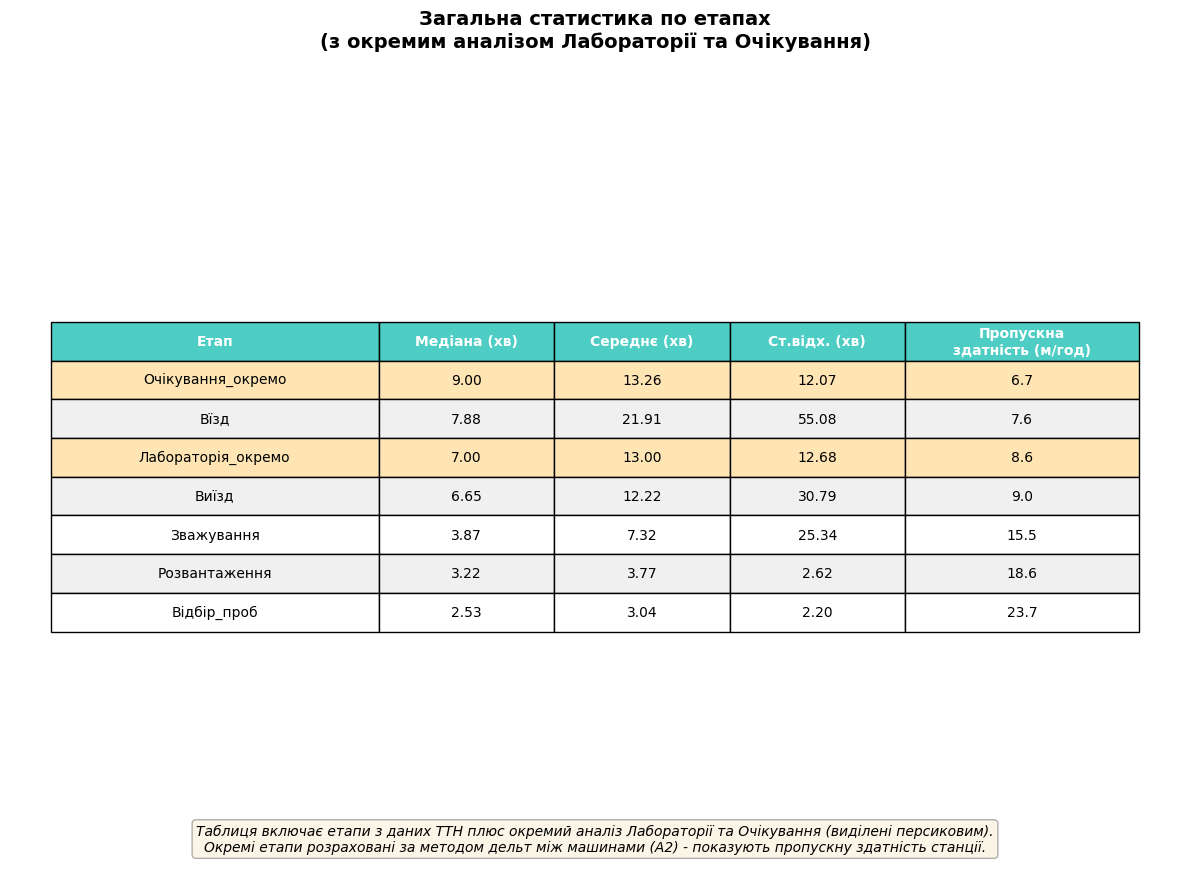

In [ ]:

print("\n" + "=" * 60)
print("ДОДАТКОВИЙ АНАЛІЗ: Лабораторія та Очікування")
print("=" * 60)

print("\n6. Створення розширеної таблиці статистики...")
fig6_combined, combined_stats = create_combined_summary_table(
    overall_bottlenecks, 
    separate_stages_file_lab='03_Лабораторія.csv',
    separate_stages_file_waiting='05_Зона очікування.csv'
)
plt.savefig('06_combined_summary_table.png', dpi=300, bbox_inches='tight')
print("   ✓ Збережено: 06_combined_summary_table.png")

# Виведення порівняння
print("\n" + "=" * 60)
print("ПОРІВНЯННЯ: Лабораторія vs Очікування")
print("=" * 60)

if 'Лабораторія_окремо' in combined_stats.index and 'Очікування_окремо' in combined_stats.index:
    lab_median = combined_stats.loc['Лабораторія_окремо', 'median']
    waiting_median = combined_stats.loc['Очікування_окремо', 'median']
    
    print(f"\nЛабораторія (окремо):")
    print(f"  Медіанний час між машинами: {lab_median:.2f} хв")
    print(f"  Пропускна здатність: {combined_stats.loc['Лабораторія_окремо', 'м_год']:.1f} м/год")
    
    print(f"\nОчікування (окремо):")
    print(f"  Медіанний час між машинами: {waiting_median:.2f} хв")
    print(f"  Пропускна здатність: {combined_stats.loc['Очікування_окремо', 'м_год']:.1f} м/год")
    
    if waiting_median > lab_median:
        print(f"\n⚠️ ВИСНОВОК: Очікування є вузьким місцем!")
        print(f"   Час очікування на {((waiting_median/lab_median - 1) * 100):.1f}% довший за час лабораторії")
    else:
        print(f"\n⚠️ ВИСНОВОК: Лабораторія є вузьким місцем!")
        print(f"   Час лабораторії на {((lab_median/waiting_median - 1) * 100):.1f}% довший за час очікування")

print("\n" + "=" * 60)

plt.show()